# Masking Data With Py-ART Gatefilters

In [1]:
# This notebook gives examples on how to use a Py-ART GateFilter object to mask data.

In [2]:
# First import needed modules.
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
# Read the radar file.
radar = pyart.io.read("sgpxsaprcmacsurI5.c1.20171004.203018.nc")

In [4]:
# See what moments are present.
radar.fields.keys()

dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'differential_phase', 'xsapr_clutter', 'sounding_temperature', 'height', 'signal_to_noise_ratio', 'velocity_texture', 'gate_id', 'simulated_velocity', 'corrected_velocity', 'unfolded_differential_phase', 'corrected_differential_phase', 'filtered_corrected_differential_phase', 'corrected_specific_diff_phase', 'filtered_corrected_specific_diff_phase', 'corrected_differential_reflectivity', 'corrected_reflectivity', 'height_over_iso0', 'specific_attenuation', 'path_integrated_attenuation', 'specific_differential_attenuation', 'path_integrated_differential_attenuation', 'rain_rate_A'])

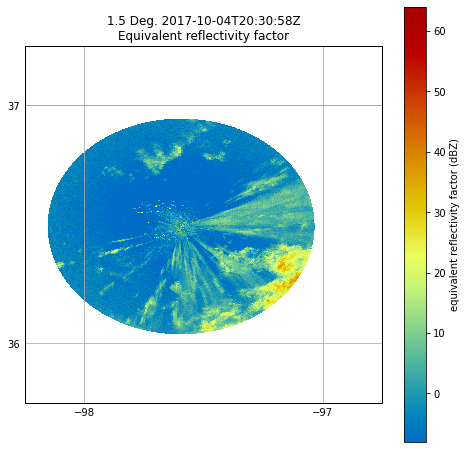

In [5]:
# When plotting, we can see second trip echoes present as well as nonhydrometeor echoes.
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    "reflectivity",
    sweep=2,
    resolution="50m",
    vmin=-8,
    vmax=64,
    min_lon=-98.25,
    max_lon=-96.75,
    min_lat=35.75,
    max_lat=37.25,
    projection=ccrs.PlateCarree(),
)
plt.show()

In [6]:
# When both displaying and analyzing such data, it is desirable to remove such echoes.
# Py-ART provides the GateFilter class for doing such filtering.
gatefilter = pyart.filters.GateFilter(radar)

In [7]:
# The below example shows how you can use a gatefilter to exclude values where gate_id is
# equal to a certain value. (You can exclude values based on conditions from multiple
# fields. In this example, we are excluding regions identified as second trip echoes
# (gate_id = 0), nonhydrometeors (gate_id = 1), and clutter (gate_id = 2).
gatefilter.exclude_equal("gate_id", 0)
gatefilter.exclude_equal("gate_id", 3)
gatefilter.exclude_equal("gate_id", 5)

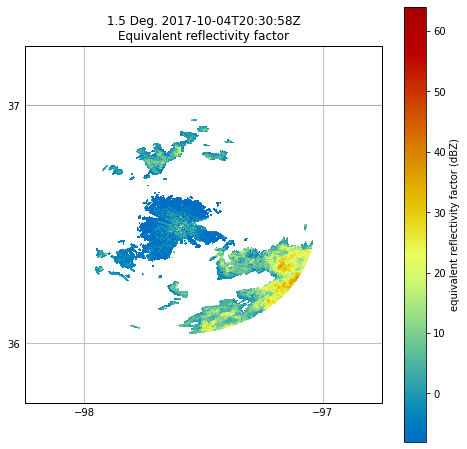

In [8]:
# The gatefilter can be then be specified as an input to plot_ppi_map()
# As you can see, much cleaner with the clutter removed.
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    "reflectivity",
    sweep=2,
    resolution="50m",
    vmin=-8,
    vmax=64,
    min_lon=-98.25,
    max_lon=-96.75,
    min_lat=35.75,
    max_lat=37.25,
    projection=ccrs.PlateCarree(),
    gatefilter=gatefilter,
)
plt.show()

In [9]:
# Let's reset the gatefilter and try another method.
gatefilter = pyart.filters.GateFilter(radar)

In [10]:
# Lets remove reflectivity values below a threshold.
gatefilter.exclude_below("reflectivity", 0)

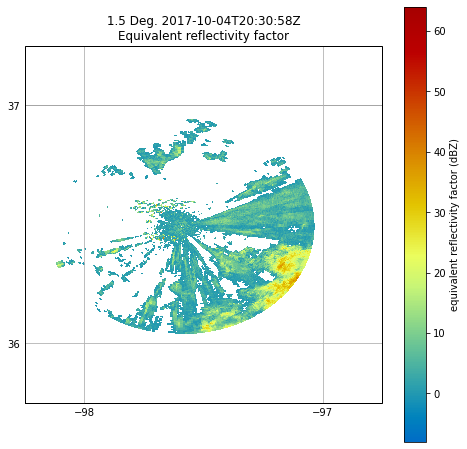

In [11]:
# Here we see reflectivity values below zero masked.
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    "reflectivity",
    sweep=2,
    resolution="50m",
    vmin=-8,
    vmax=64,
    min_lon=-98.25,
    max_lon=-96.75,
    min_lat=35.75,
    max_lat=37.25,
    projection=ccrs.PlateCarree(),
    gatefilter=gatefilter,
)
plt.show()

In [12]:
# The structure of the gatefilter includes boolean arrays of the same shape as the radar
# fields that tell you whether a gate is excluded (gatefilter.gate_excluded) or included
# (gatefilter.gate_included). These can be used to do calculations on the data that
# include the filter. For example, if we want to get the mean reflectivity of each sweep, we can do:
refl_array = np.ma.masked_where(
    gatefilter.gate_included == False, radar.fields["reflectivity"]["data"]
)
reflectivity_w_mask = [refl_array[x].mean() for x in radar.iter_slice()]
reflectivity = [
    radar.fields["reflectivity"]["data"][x].mean() for x in radar.iter_slice()
]
print(reflectivity)
print(reflectivity_w_mask)

[0.9344453454202706, -0.620691732853737, -2.3756584054113996, -5.597935968662154, -7.696735014111216, -9.061894569912447, -9.721673265240488, -10.086695918593689, -10.33930700509078, -10.599363169483158, -10.836875745223637, -11.051601529570966, -11.22435547210836, -11.378109469982695, -11.553820234067336, -11.648943841665002, -11.837593740986444, -12.049614721040282, -12.331202567459613, -12.585432697375357, -12.87002341270722, -12.993012637722325, -13.061966001642219, -13.122799449619672]
[6.861035552720102, 6.74608994279257, 6.148801770281325, 5.70860719727862, 5.989513966551444, 5.188644935344827, 4.89301878240611, 5.172644371021923, 5.79879842243138, 4.912806090219976, 4.766281467013889, 4.920522471877334, 4.898600907318164, 4.971026055481874, 5.110503947133682, 5.094456418731509, 5.0822160050675675, 5.036430544969512, 5.259332430219459, 5.2438254054588604, 5.473482666015625, 5.574283685503023, 5.866719139946832, 5.771468742643597]
